##  XgBoost for demand forecasting

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
import datetime 
# Calling the fromtimestamp() function to
# extract datetime from the given timestamp
# from google.colab import drive
# drive.mount('/content/drive')
ride = pd.read_csv("rideshare_kaggle.csv")
# ride = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/rideshare_kaggle.csv")
ride['timestamp']=pd.to_datetime(ride['timestamp'], unit='s')
ride.dropna(axis=0,inplace=True)
ride["Date"] = ride["timestamp"].dt.date
ride["Time"] = ride["timestamp"].dt.time
ride["Weekday"]=ride["timestamp"].dt.day_name()

##  Data preprocessing and cleaning

In [4]:
ride['datetime']=pd.to_datetime(ride['datetime'])

In [5]:
ride['Date']=pd.to_datetime(ride['Date'])

In [6]:
grouped = ride.groupby(ride['datetime'].dt.floor('h'))['id'].count().reset_index()
grouped.rename(columns={'id': 'total_rides'}, inplace=True)

In [7]:
grouped.head()

,datetime,total_rides
0,2018-11-26 03:00:00,77
1,2018-11-26 04:00:00,390
2,2018-11-26 05:00:00,616
3,2018-11-26 06:00:00,1462
4,2018-11-26 07:00:00,925


In [8]:

grouped.set_index('datetime',inplace=True)

In [9]:
len(grouped)

332

## Xgboost

***This graph above shows the distribution of count of rides by hour for each day of the two month dataset***

In [10]:
grouped.index=pd.to_datetime(grouped.index)
grouped.head()

,total_rides
datetime,
2018-11-26 03:00:00,77
2018-11-26 04:00:00,390
2018-11-26 05:00:00,616
2018-11-26 06:00:00,1462
2018-11-26 07:00:00,925


In [11]:

train = grouped.loc[grouped.index < '2018-12-16']
test = grouped.loc[grouped.index >= '2018-12-16']



In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    
    return df

df = create_features(grouped)

In [13]:

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month']
TARGET = 'total_rides'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=24, gap=6)
df = df.sort_index()

***Here we will split the data using timeseries split which is more suitable for timeseries data***

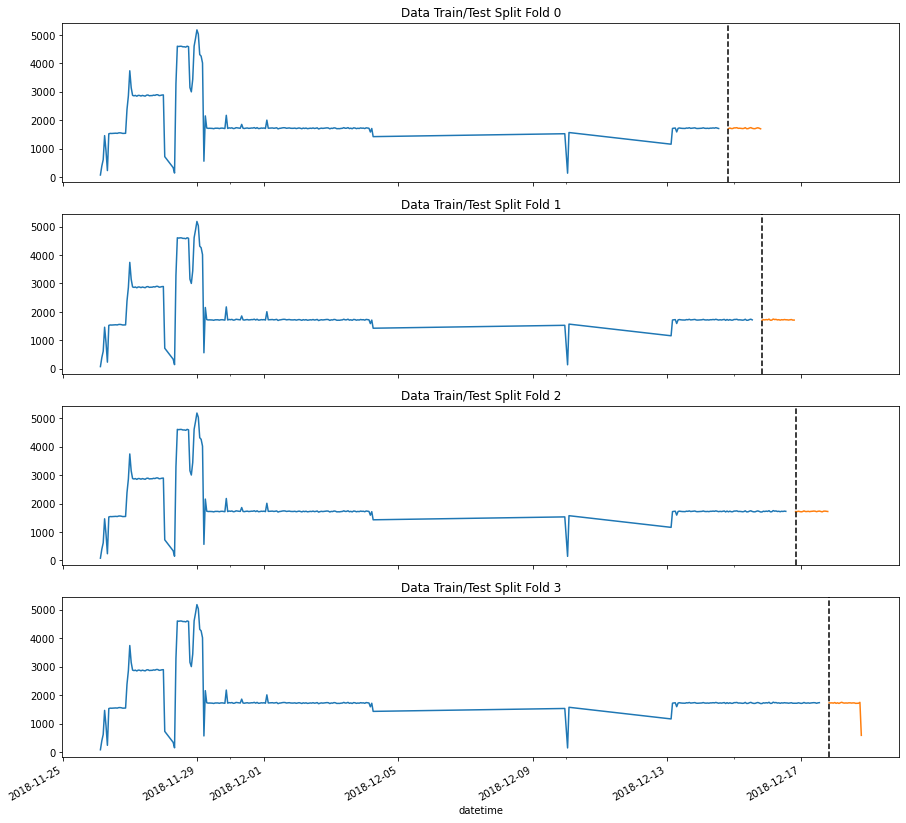

In [15]:

fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['total_rides'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total_rides'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [16]:
#adding the lags for timeseries

In [17]:
def add_lags(df):
    target_map = df['total_rides'].to_dict()
    
    df['lag1'] = (df.index - pd.Timedelta('24 hours')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('48 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('72 hours')).map(target_map)
    return df

In [18]:
df = add_lags(df)

## Running XGboost with CV-4 folds 

In [19]:



fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
        
    X_train = train.drop(['total_rides'],axis=1)
    y_train = train['total_rides']

    X_test = test.drop(['total_rides'],axis=1)
    y_test = test['total_rides']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=2,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.extend(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2181.71447	validation_1-rmse:1704.38670
[100]	validation_0-rmse:963.92043	validation_1-rmse:657.85133
[200]	validation_0-rmse:562.68902	validation_1-rmse:211.29765
[254]	validation_0-rmse:486.86099	validation_1-rmse:242.55130
[10:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2141.22729	validation_1-rmse:1706.70551
[100]	validation_0-rmse:939.61204	validation_1-rmse:645.69093
[200]	validation_0-rmse:555.70149	validation_1-rmse:236.22796
[300]	validation_0-rmse:446.46264	validation_1-rmse:137.79013
[400]	validation_0-rmse:388.65751	validation_1-rmse:130.52979
[415]	validati

In [20]:
X_test = test.drop(['total_rides'],axis=1)
len(X_test)

24

In [21]:

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 159.8264
Fold scores:[207.14867310622387, 128.99194837891062, 71.52720065302476, 231.63772666583952]


***Average of the four folds gives a RMSE score of 159.82- Better than previous model but still can be improved***

/var/folders/1j/vhrxwjz94tn0tsz00qlnqw8m0000gn/T/ipykernel_52328/577023577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


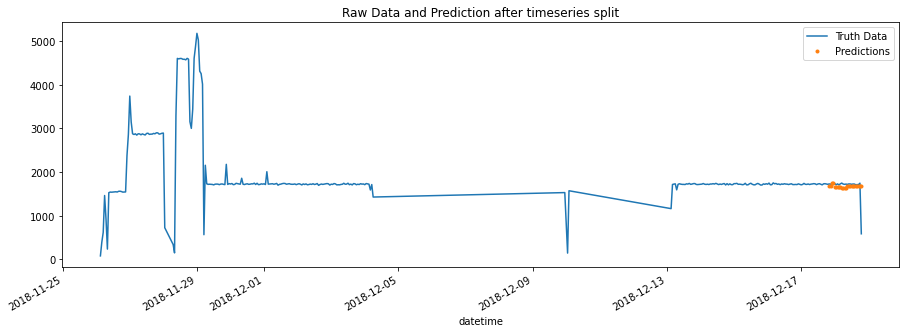

In [22]:
test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_rides']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction after timeseries split')
plt.show()

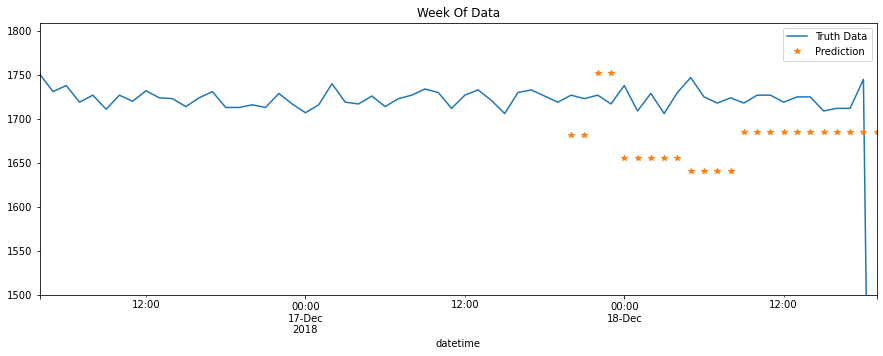

In [23]:
ax = df.loc[(df.index > '2018-12-16 03:00:00 ') & (df.index < '2018-12-25 00:00:00')]['total_rides'] \
    .plot(figsize=(15, 5), title='Week Of Data').set_ylim(1500)
test.loc[(test.index > '2018-12-16 03:00:00') & (test.index < '2018-12-25 00:00:00')]['prediction'] \
    .plot(style='*')
plt.legend(['Truth Data','Prediction'])
plt.show()


#  1.2 d Hyper parameter tuning and outlier handling








***Removing data lesser than 750 counts and greater that 4500***

In [24]:
df = df.query('total_rides > 750').copy()
df=df.query('total_rides < 4500').copy()

In [25]:
df.head()

,total_rides,hour,dayofweek,quarter,month,dayofmonth,lag1,lag2,lag3
datetime,,,,,,,,,
2018-11-26 06:00:00,1462,6,0,4,11,26,NaN,NaN,NaN
2018-11-26 07:00:00,925,7,0,4,11,26,NaN,NaN,NaN
2018-11-26 09:00:00,1526,9,0,4,11,26,NaN,NaN,NaN
2018-11-26 10:00:00,1541,10,0,4,11,26,NaN,NaN,NaN
2018-11-26 11:00:00,1538,11,0,4,11,26,NaN,NaN,NaN


In [26]:
# Running the model with reduced dataset --> removed few outliers

***hyperparameter tuning for XGboost***


In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [500,1000],
#     'subsample': [0.5, 0.7, 1.0],
#     'gamma': [0, 1, 5]
# }



# # Instantiate the XGBRegressor model
# xgb_model = xgb.XGBRegressor()

# # Instantiate the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the grid search object to the data
# grid_search.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)

# # Print the best hyperparameters and the best score
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)




In [29]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
        
    X_train = train.drop(['total_rides'],axis=1)
    y_train = train['total_rides']

    X_test = test.drop(['total_rides'],axis=1)
    y_test = test['total_rides']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1975.06649	validation_1-rmse:1705.22225
[100]	validation_0-rmse:766.86968	validation_1-rmse:646.10623
[200]	validation_0-rmse:328.73144	validation_1-rmse:251.69250
[300]	validation_0-rmse:178.62684	validation_1-rmse:99.80584
[400]	validation_0-rmse:142.03118	validation_1-rmse:39.40804
[500]	validation_0-rmse:123.45327	validation_1-rmse:20.21245
[600]	validation_0-rmse:110.02609	validation_1-rmse:18.89406
[624]	validation_0-rmse:107.66837	validation_1-rmse:21.10267
[10:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1948.73540	validation_1-rmse:1705.82727
[100]	validation_0-

In [30]:

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}') 


Score across folds 23.1732
Fold scores:[18.046861944204206, 18.67970362522241, 40.149977999915876, 15.81624221445832]


/var/folders/1j/vhrxwjz94tn0tsz00qlnqw8m0000gn/T/ipykernel_52328/2478601107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


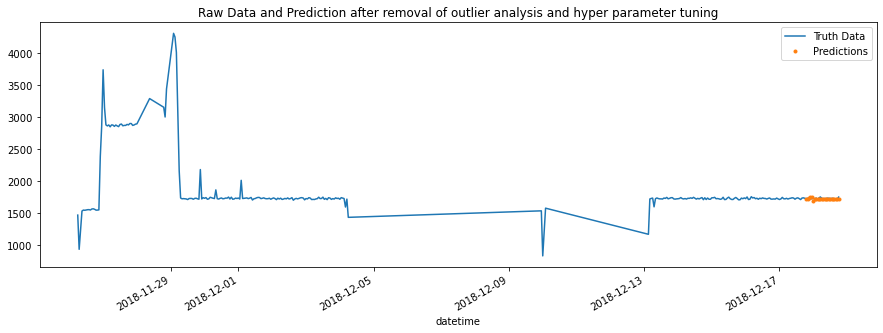

In [31]:
test['prediction'] = reg.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_rides']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction after removal of outlier analysis and hyper parameter tuning')
plt.show()

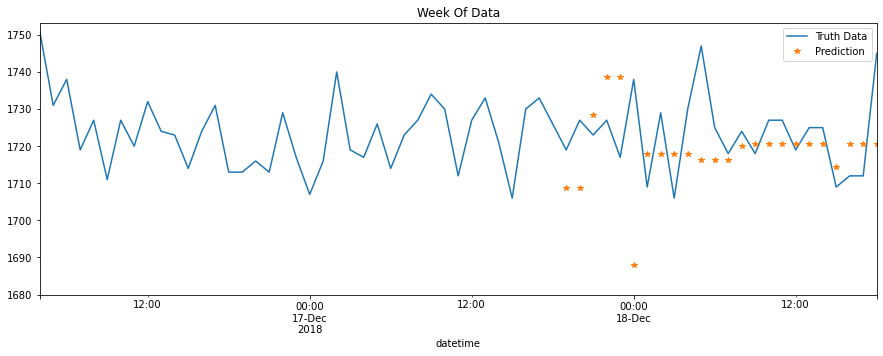

In [32]:
ax = df.loc[(df.index > '2018-12-16 03:00:00 ') & (df.index < '2018-12-25 00:00:00')]['total_rides'] \
    .plot(figsize=(15, 5), title='Week Of Data').set_ylim(1680)
test.loc[(test.index > '2018-12-16 03:00:00') & (test.index < '2018-12-25 00:00:00')]['prediction'] \
    .plot(style='*')
plt.legend(['Truth Data','Prediction'])
plt.show()

***As we can see above that the model is able to predict much better and is giving an RMSE score of 23 ---> way better than Sarimax***

In [33]:
X_test.head()

,hour,dayofweek,quarter,month,dayofmonth,lag1,lag2,lag3
datetime,,,,,,,,
2018-12-17 19:00:00,19,0,4,12,17,1713.0,1702.0,1734.0
2018-12-17 20:00:00,20,0,4,12,17,1716.0,1703.0,1707.0
2018-12-17 21:00:00,21,0,4,12,17,1713.0,1729.0,1730.0
2018-12-17 22:00:00,22,0,4,12,17,1729.0,1719.0,1711.0
2018-12-17 23:00:00,23,0,4,12,17,1717.0,1732.0,1711.0


In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 23.1732
Fold scores:[18.046861944204206, 18.67970362522241, 40.149977999915876, 15.81624221445832]


In [35]:
df.index.max()

Timestamp('2018-12-18 18:00:00')

In [43]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month','dayofmonth','lag1','lag2','lag3']
future = pd.date_range('2018-12-18','2018-12-25', freq='3h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

## Future Predictions - Interactive graph

In [44]:
# !pip install plotly==5.2.1
# !pip install ipywidgets

import ipywidgets as widgets
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Define date range slider
date_range_slider = widgets.SelectionRangeSlider(
    options=future_w_features.index,
    index=(0, len(future_w_features.index) - 1),
    description='Date Range:',
    layout=widgets.Layout(width='80%')
)

# Define frequency dropdown
freq_dropdown = widgets.Dropdown(
    options=['1h', '2h', '3h', '4h', '6h', '12h', '24h'],
    value='3h',
    description='Frequency:',
    layout=widgets.Layout(width='20%')
)



# Define update function for the plot
def update_plot(date_range, freq):
    # Get the selected date range
    start_date, end_date = date_range

    # Resample the dataframe at the selected frequency
    filtered_df = future_w_features.resample(freq).mean()
    filtered_df = filtered_df.loc[start_date:end_date]

    # Create traces for the line plot and scatter plot
    line_trace = go.Scatter(x=filtered_df.index, y=filtered_df['pred'], mode='lines', name='Prediction')
    scatter_trace = go.Scatter(x=filtered_df.index, y=filtered_df['pred'], mode='markers', marker=dict(color='red'), name='Prediction')

    # Create subplot with the line plot and scatter plot
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    fig.add_trace(line_trace, row=1, col=1)
    fig.add_trace(scatter_trace, row=1, col=1)

    # Set x-axis and y-axis labels
    fig.update_xaxes(title_text='Date', tickformat='%m/%d/%Y %H:%M')
    fig.update_yaxes(title_text='Demand Prediction')

    # Set plot title
    title_text = f"Future Predictions for {start_date} - {end_date} (Frequency: {freq})"
    fig.update_layout(title_text=title_text, title_font_size=15)
    # Show plot
    pio.renderers.default = "notebook"
#     pio.renderers.default = "browser"
    fig.show()

# Display the date range slider and frequency dropdown
widgets.interact(update_plot, date_range=date_range_slider, freq=freq_dropdown);


interactive(children=(SelectionRangeSlider(description='Date Range:', index=(0, 56), layout=Layout(width='80%'…

*Steps to interact: The user can use the date range slider to select the range of the dates for which he would like the model to predict future demand.*
The user can also change the frequency of the data points in time for the prediction(eg 3h,6h etc)*

*This Graph shows the future demand prediction using XGBoost- best model.*

*It is created using plotly and ipwidgets*
